In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn

import gymnax
import equinox as eqx
import dill
import matplotlib.pyplot as plt

from helpers import dataloader, rollout_parallel
from ode import train_dynamics
from models import NeuralNetwork, NeuralODE
from helpers import rollout_parallel


In [2]:
def rollout_on_real_sys(key, params, model_static, env_params, n_trajectories):
    # Rollout 
    keys_rollout = jr.split(key, n_trajectories)
    obss, actionss, rewardss, _, _= rollout_parallel(keys_rollout, params, model_static, env_params)
    # Return data
    data = jnp.concatenate([obss, jnp.expand_dims(actionss, axis=-1)], axis=2)
    # Get length of rollout
    ts = jnp.linspace(0, env_params.dt * env_params.max_steps_in_episode, env_params.max_steps_in_episode)

    return ts, data, rewardss

In [3]:
SEED = 0
key_policy, key_rollout, key_ODE = jr.split(jr.PRNGKey(SEED), 3)
len_strat = (0.5, )

# Generate rollout on policy
# policy = NeuralNetwork(input_size=3 , output_size=3, width_size=50, depth=1, key=key_policy)
with open('../weights/policy/gamma.pkl', 'rb') as file:
    policy = dill.load(file)

policy_params, policy_static = eqx.partition(policy, eqx.is_inexact_array)
_, env_params = gymnax.make("Pendulum-v1")
n_trajectories = 100
ts, data, reward = rollout_on_real_sys(key_rollout, policy_params, policy_static, env_params, n_trajectories)

# Train ODE with rolllout data
ODE_model = NeuralODE(4, 3, width_size=20, depth=4, key=key_ODE)
ODE_params, ODE_static = eqx.partition(ODE_model, eqx.is_inexact_array)
ys, losses, ODE_model = train_dynamics(data, ts, ODE_params, ODE_static, key=key_ODE, 
                                       lr_strategy=(3e-3, 3e-3, 3e-3),
                                       steps_strategy=(500, 500, 500), 
                                       length_strategy=(0.10, 0.50, 1.0))

2023-12-27 22:17:10.568380: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:273] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Step: 0, Loss: 5.853053092956543, Computation time: 8.38999080657959
Step: 100, Loss: 2.3760461807250977, Computation time: 0.009884119033813477
Step: 200, Loss: 1.063145637512207, Computation time: 0.0076253414154052734
Step: 300, Loss: 1.1471143960952759, Computation time: 0.00876927375793457
Step: 400, Loss: 0.2890259325504303, Computation time: 0.006507158279418945
Step: 499, Loss: 0.3349921405315399, Computation time: 0.007596015930175781
Step: 0, Loss: 1.84163236618042, Computation time: 8.371207237243652
Step: 100, Loss: 1.6500643491744995, Computation time: 0.010743141174316406
Step: 200, Loss: 1.1834157705307007, Computation time: 0.010127782821655273
Step: 300, Loss: 0.86070317029953, Computation time: 0.012138128280639648
Step: 400, Loss: 1.0011630058288574, Computation time: 0.010516166687011719
Step: 499, Loss: 0.7428923845291138, Computation time: 0.01209402084350586
Step: 0, Loss: 0.28722065687179565, Computation time: 8.266708850860596
Step: 100, Loss: 0.464781910181045

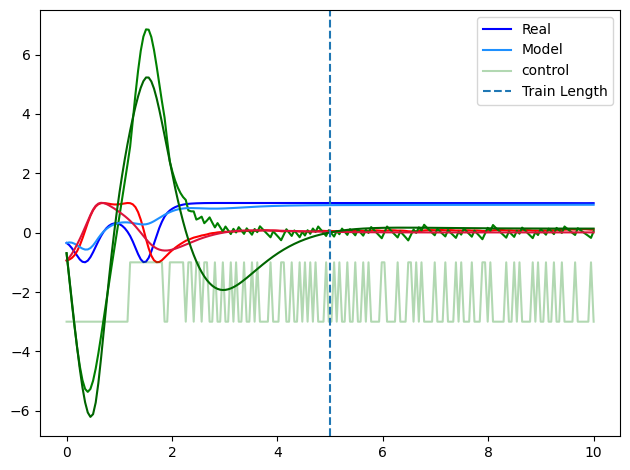

In [4]:
y0 = data[0, 0, :-1]
us = data[0, :, -1]

plt.plot(ts, data[0, :, 0], c="blue", label="Real")
plt.plot(ts, data[0, :, 1], c="red")
plt.plot(ts, data[0, :, 2], c="green")

model_y = ODE_model(ts, y0, us)

plt.plot(ts, model_y[:, 0], c="dodgerblue", label="Model")
plt.plot(ts, model_y[:, 1], c="crimson")
plt.plot(ts, model_y[:, 2], c="darkgreen")

plt.plot(ts, us - 2, c="green", alpha=0.3, label='control')
plt.axvline(ts[-1] * len_strat[0], linestyle='--', label='Train Length')

plt.legend()
plt.tight_layout()

plt.show()

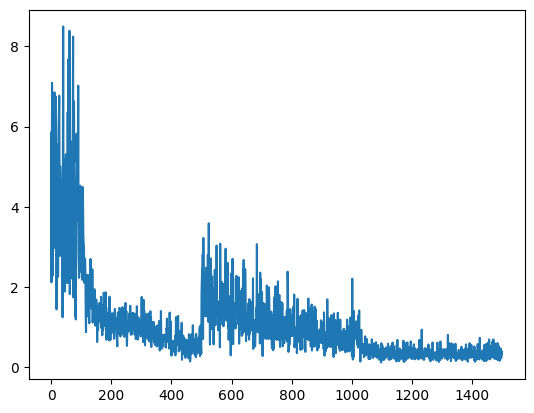

In [5]:
plt.plot(losses)